In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, month_plot
from arch.unitroot import ADF, KPSS
from pmdarima import auto_arima
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import Holt
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import evds as ev

In [2]:
with open("/Users/neseuygun/Desktop/evds_api_key.txt") as file:
    api = file.read()

evds = ev.evdsAPI(api)
data = evds.get_data(["TP.AC2.TOP.A"], startdate="01-03-2011", enddate="01-09-2023")
data

,Tarih,TP_AC2_TOP_A
0,2011-3,5276.0
1,2011-4,4777.0
2,2011-5,4431.0
3,2011-6,4857.0
4,2011-7,4024.0
...,...,...
146,2023-5,10336.0
147,2023-6,9656.0
148,2023-7,9608.0
149,2023-8,10844.0


In [3]:
data.rename(columns={"Tarih":"Date", "TP_AC2_TOP_A":"Firm Number"}, inplace=True)
data["Date"] = pd.date_range("01-03-2011", periods=len(data), freq="M")
data.set_index("Date", inplace=True)
data

,Firm Number
Date,
2011-01-31,5276.0
2011-02-28,4777.0
2011-03-31,4431.0
2011-04-30,4857.0
2011-05-31,4024.0
...,...
2023-03-31,10336.0
2023-04-30,9656.0
2023-05-31,9608.0


In [4]:
data.isna().sum()

Firm Number    0
dtype: int64

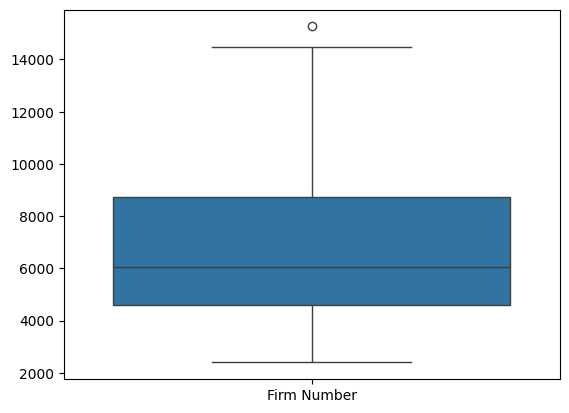

In [5]:
# ARIMA models are sensitivity to outlier. so we need to chech if there is outlier in the series.

sns.boxplot(data)
plt.show()

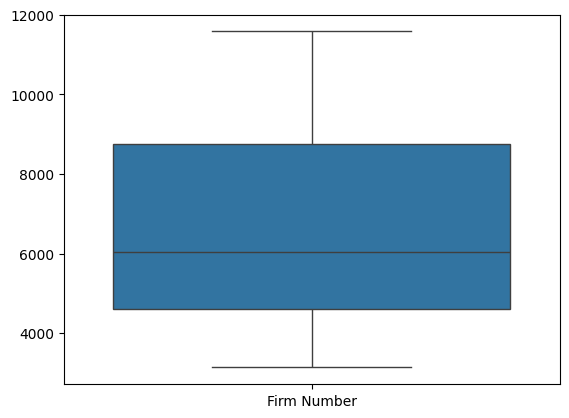

In [6]:
# now we need to handle with the outliers.
data["Firm Number"] = winsorize(data["Firm Number"], (0.05, 0.05))

sns.boxplot(data)
plt.show()

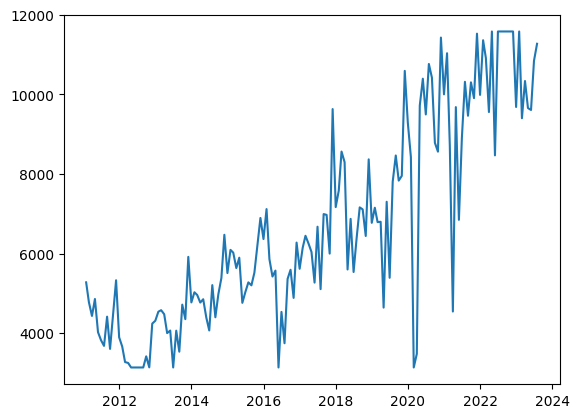

In [7]:
# now quick check trend
plt.plot(data)
plt.show()

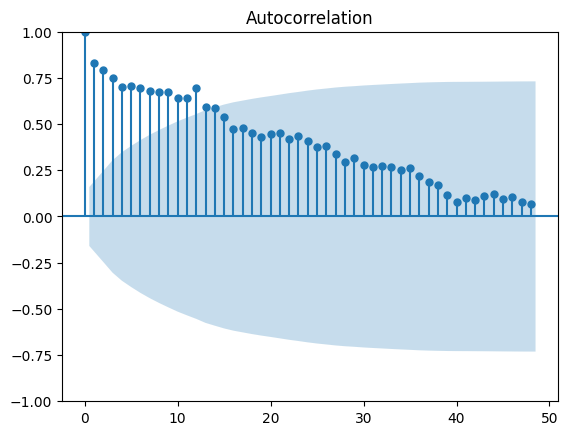

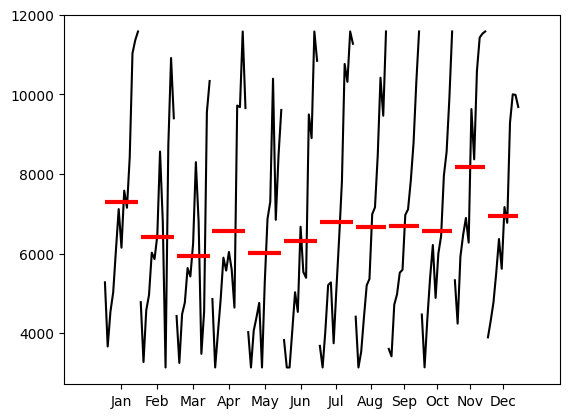

In [8]:
#check seasonality
plot_acf(data, lags=48)
month_plot(data)
plt.show()

In [9]:
# lets split the data as train and test datasets
train = data.iloc[:-24]
test = data.iloc[-24:]

In [10]:
#cheking whether the series is stationary with ADF nd KPSS statistical tests.
adf = ADF(train)
kpss = KPSS(train)

print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                  0.021
P-value                         0.960
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  1.630
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


according tp stastical test result the series is not stationary

In [11]:
# take difference to make stationary the series
datadiff = train.diff().dropna()

adf = ADF(datadiff)
kpss = KPSS(datadiff)

print(adf)
print(kpss)

   Augmented Dickey-Fuller Results   
Test Statistic                 -4.890
P-value                         0.000
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.156
P-value                         0.371
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


/Users/neseuygun/miniconda3/lib/python3.11/site-packages/arch/unitroot/unitroot.py:785: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]


Now we are able to make the series stationary by taking first difference and we can say there is not seasonality

In [12]:
# Set up the model
model = auto_arima(train, trace=True, seasonal=False)
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2197.468, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2182.681, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2170.903, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2195.567, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2171.044, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.412 seconds


ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

As we see in the arima result the model take 1 difference for d parameter to make stationary the series

In [13]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1082.451
Date:                Fri, 29 Dec 2023   AIC                           2170.903
Time:                        09:47:44   BIC                           2179.412
Sample:                    01-31-2011   HQIC                          2174.360
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     42.2169     17.269      2.445      0.015       8.369      76.064
ma.L1         -0.8656      0.042    -20.616      0.000      -0.948      -0.783
sigma2      1.678e+06    1.5e+05     11.160      0.0

In [14]:
model.aic()

2170.902774713274

In [20]:
#lets check other model with arima that include seasonality m period and see aic results

results = {}

for i in range(2,13):
    smodel = auto_arima(train, trace=False, seasonal=True, m=i)
    key = 'm' + str(i)
    results[key] = smodel.aic()

print(results)


{'m2': 2157.8095711342226, 'm3': 2170.902774713274, 'm4': 2146.402891717958, 'm5': 2169.1033864746105, 'm6': 2143.0030357521314, 'm7': 2170.902774713274, 'm8': 2170.902774713274, 'm9': 2170.902774713274, 'm10': 2170.902774713274, 'm11': 2170.902774713274, 'm12': 2136.2973157476863}


In [23]:
#Sort the dictionary items based on AIC values
sorted_results = sorted(results.items(), key=lambda x:x[1])
sorted_results

[('m12', 2136.2973157476863),
 ('m6', 2143.0030357521314),
 ('m4', 2146.402891717958),
 ('m2', 2157.8095711342226),
 ('m5', 2169.1033864746105),
 ('m3', 2170.902774713274),
 ('m7', 2170.902774713274),
 ('m8', 2170.902774713274),
 ('m9', 2170.902774713274),
 ('m10', 2170.902774713274),
 ('m11', 2170.902774713274)]

In [25]:
# Get the two items with the lowest AIC values
min_two_results = sorted_results[:2]
min_two_results

[('m12', 2136.2973157476863), ('m6', 2143.0030357521314)]

In [26]:
#lets use new model that contains seasonality with m12 period
model2 = auto_arima(train, trace=True, seasonal=True, m=12)
model2

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2197.468, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2162.170, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2150.123, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2195.567, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2170.903, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2152.081, Time=0.22 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2152.067, Time=0.89 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2152.516, Time=0.22 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2161.901, Time=0.15 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2156.354, Time=0.40 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : 

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [27]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood               -1064.149
Date:                            Fri, 29 Dec 2023   AIC                           2136.297
Time:                                    13:15:13   BIC                           2147.642
Sample:                                01-31-2011   HQIC                          2140.906
                                     - 07-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4774      0.074      6.417      0.000       0.332       0.623
ma.L1         -0.9162      0.034    -27.128      0.000      -0.982      -0.850
ma.S.L12       0.5684      0.099      5.714      0.000       0.373       0.763
sigma2      1.202e+06   9.73e+04     12.358      0.000    1.01e+06    1.39e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               188.73
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               7.32   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# now check if the error has white noise or not
error1 = model.resid()
error2 = model2.resid()

q1 = acorr_ljungbox(error1)
q2 = acorr_ljungbox(error2)
print(q1)
print()
print(q2)

      lb_stat  lb_pvalue
1    9.635450   0.001909
2   10.533605   0.005160
3   10.730665   0.013275
4   16.816249   0.002098
5   19.370703   0.001639
6   20.129154   0.002627
7   21.592299   0.002986
8   21.664020   0.005578
9   21.666970   0.009997
10  21.724973   0.016569

     lb_stat  lb_pvalue
1   0.001803   0.966133
2   0.003717   0.998143
3   0.160691   0.983671
4   2.459345   0.651930
5   2.468977   0.781160
6   2.616305   0.855231
7   2.630757   0.916933
8   2.819762   0.945154
9   3.050525   0.962258
10  3.056490   0.980063


As we see the p-values of both model for resid, we can say model2 is in white noise process.

In [31]:
# if you want to predict train data values, use below comand
prediction = model2.fittedvalues()
prediction

Date
2011-01-31       0.000000
2011-02-28    4377.404881
2011-03-31    4231.958206
2011-04-30    4104.506709
2011-05-31    4431.996931
                 ...     
2021-03-31    7898.456470
2021-04-30    9332.889693
2021-05-31    9737.454972
2021-06-30    8067.381862
2021-07-31    9434.880352
Length: 127, dtype: float64

In [32]:
#prediction error
def error(y_true, y_pred):
    print("MSE: {}".format(mean_squared_error(y_true, y_pred)))
    print("RMSE: {}".format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print("MAE: {}".format(mean_absolute_error(y_true, y_pred)))
    print("R2: {}".format(r2_score(y_true, y_pred)))

error(train, prediction)

MSE: 1442682.453483123
RMSE: 1201.117168923633
MAE: 784.2047468987136
R2: 0.6593981059498353


In [34]:
#lets predict test values
predict_feture = model2.predict(24)
predict_feture

error(test, predict_feture)

MSE: 4470965.260865562
RMSE: 2114.465715225849
MAE: 1917.643494652408
R2: -3.9132921676362837


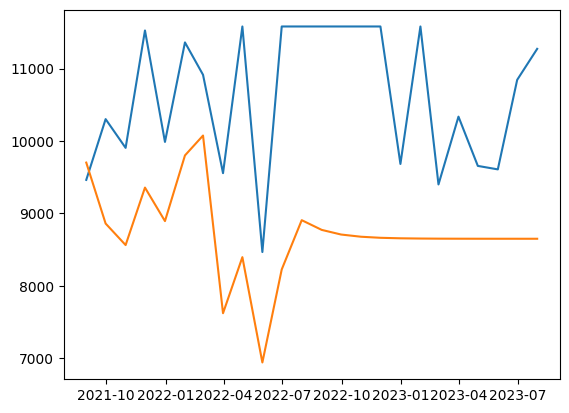

In [35]:
plt.plot(test, label="test data")
plt.plot(predict_feture, label="prediction")
plt.show()

As we see the graph above, the model is not successfull